# PBH inside the Sun

In [4]:
import os

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import integrate
from scipy.optimize import minimize
from scipy.interpolate import interp1d

from astropy import constants as cnt
from astropy import units as unt
#from astropy import physical_constants, astronomical_constants

#import dask.dataframe as dd
#import dask.array as da

#from uncertainties import ufloat, unumpy

#from joblib import Parallel, delayed

#from tqdm.notebook import tqdm

#from ipywidgets import interact, FloatSlider, IntSlider

In [5]:
import seaborn as sns
sns.set(style="ticks", palette="muted", rc={"xtick.bottom" : True, "ytick.left" : True})
#plt.style.use('figs/thinfig')
red = "#CA0020"
orange = "#F97100" 
blue = "#0571b0"

M_sun = 1.989e33
R_sun = 6.954e10

In [6]:
# labels 
density     = r'density $\mathbf{\rho~/~[g/cm^3]}$'
frac_radius = r'fractional radius $\mathbf{r/R_\odot}$'
frac_mass   = r'fractional mass $\mathbf{m/M_\odot}$'
Teff        = r'effective temperature $\mathbf{T_{eff}/K}$'
luminosity  = r'luminosity $\mathbf{L/L_\odot}$'

In [7]:
#dirs = os.listdir('sep_pbh_grid/grid')
dirs = os.listdir('.')
dirs = [d for d in dirs if d.startswith('M=')]

print(dirs)

data = {}
for d in dirs:
    M, MBHf = d.split('_')
    M = float(M[2:])
    MBHf = float(MBHf[5:])
    file_path = os.path.join( d, 'LOGS', 'history.data')
    #file_path = os.path.join('pbh_grid', d, 'history.data')
    print(file_path)
    if not os.path.exists(file_path):
        continue
    df = pd.read_table(file_path, sep='\s+', skiprows=5)
    data[(M, MBHf)] = df[['star_age', 'log_L', 'log_Teff', 'center_h1', 'M_BH', 'log_LH', 'L_BH','L_E','R_B','cs_center','M_dot','log10(dm/dt)']]

data

['M=0.1_MBHf=-11', 'M=0.5_MBHf=-11', 'M=1.0_MBHf=-11', 'M=1.0_MBHf=-10']
M=0.1_MBHf=-11/LOGS/history.data
M=0.5_MBHf=-11/LOGS/history.data
M=1.0_MBHf=-11/LOGS/history.data
M=1.0_MBHf=-10/LOGS/history.data


{(0.1,
  -11.0):          star_age     log_L  log_Teff  center_h1          M_BH     log_LH  \
 0    1.000000e-05 -0.274424  3.450363   0.722545  1.000000e-10 -20.548326   
 1    1.004688e-05 -0.274424  3.450363   0.722545  1.000000e-10 -20.548326   
 2    1.004980e-05 -0.274424  3.450363   0.722545  1.000000e-10 -20.548326   
 3    1.005017e-05 -0.274424  3.450363   0.722545  1.000000e-10 -20.548326   
 4    1.005054e-05 -0.274424  3.450363   0.722545  1.000000e-10 -20.548326   
 ..            ...       ...       ...        ...           ...        ...   
 587  9.659173e+09 -2.949303  3.490670   0.719648  1.101386e-07  -2.977041   
 588  1.061618e+10 -2.938413  3.491722   0.719372  2.173452e-07  -2.992961   
 589  1.159006e+10 -2.918328  3.493595   0.719110  4.240892e-07  -3.024008   
 590  1.238577e+10 -2.884073  3.496643   0.718922  8.108927e-07  -3.080466   
 591  1.300000e+10 -2.830548  3.501037   0.718806  1.357705e-06  -3.176782   
 
              L_BH           L_E           R_B

6.558554374508969
5.703796763521416
6.558554374508969
-0.8547576109875517
-0.8374338892039628
1.6523411268345197e-06
-6.0
-5.0
-4.0
-3.0
-2.0


ValueError: A value in x_new is above the interpolation range.

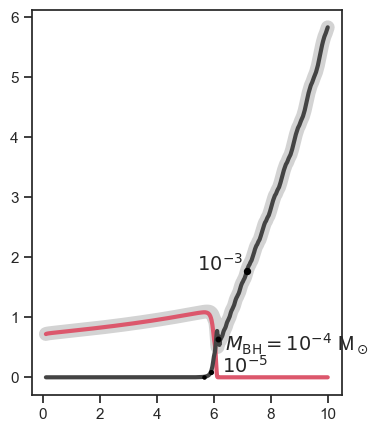

In [10]:
plt.figure(figsize=(4, 5))

norm = mpl.colors.LogNorm(vmin=10**-20, vmax=1)
cmap = plt.get_cmap('Reds')

for key, df in data.items():
    M, MBHf = key
    if M == 1.0 and MBHf==-11:
        df = df[df['center_h1'] < df['center_h1'].values[0]*0.995].reset_index()
        
        plt.plot(df['star_age']/1e9, 10**df['log_L'], lw=10, c='lightgray', zorder=-99, label=r'$L_\ast$')
        plt.plot(df['star_age']/1e9, 10**df['log_LH'], lw=3, c="#dc576c", label='fusion', zorder=99)#, c=cmap(norm(10**MBHf)))
        plt.plot(df['star_age']/1e9, df['L_BH'], lw=3, c='#444444', label='accretion', zorder=99)#, c=cmap(norm(10**MBHf)))
        
        print((df['star_age'][(df['L_BH']<=1).argmin()])/1e9)
        print((df['star_age'][(df['L_BH']<=0.01).argmin()])/1e9)
        print((df['star_age'][(df['L_BH']<=1).argmin()])/1e9)
        print((df['star_age'][(df['L_BH']<=0.01).argmin()] - df['star_age'][(df['L_BH']<=1).argmin()])/1e9)
        print((df['star_age'][(df['L_BH']<=1).argmin()])/1e9 - (df['star_age'][(df['L_BH']<=2).argmin()])/1e9)
        print(df['M_BH'][np.argmin(df['L_BH']<0.01)])
        
        LBH_func = interp1d(df['star_age']/1e9, df['L_BH'])
        MBH_func = interp1d(df['M_BH'], df['star_age']/1e9)
        masses = np.linspace(-6, -2, num=5)
        for mass in masses:
            print(mass)
            MBH_at_age = MBH_func(10**mass)
            L_BH_at_age = LBH_func(MBH_at_age)
            plt.plot(MBH_at_age, L_BH_at_age, 'o', c='#000000', zorder=99, ms=(15/-mass)**0.9)
            if mass != -4 and mass != -6 and mass != -1 and mass != -5:
                plt.text(0.98*MBH_at_age - (0.3 if mass == -2 else -0.1 if mass == -5 else 0), 
                         L_BH_at_age, r"$10^{"+str(int(mass))+"}$", ha='right', size=14,
                    zorder=9999999)
            elif mass == -4: 
                plt.text(MBH_at_age + 0.25, L_BH_at_age*0.7, 
                         r"$M_{\rm{BH}} = 10^{"+str(int(mass))+"}$ M$_\odot$", ha='left', size=14,
                    zorder=9999999)
            elif mass == -5:
                plt.text(MBH_at_age + 0.4, L_BH_at_age*0.8, 
                         r"$10^{"+str(int(mass))+"}$", ha='left', size=14,
                    zorder=9999999)

plt.axhline(10**0, ls='--', c='k')
plt.axvline(4.572, ls='--', c='k')

plt.semilogy()
plt.ylim([0.5e-2, 30])
plt.gca().set_yticks([10**-2, 10**-1, 1, 10])
plt.gca().set_yticklabels(['0.01', '0.1', '1', '10'])

plt.title(r'initial $M_{BH} = 10^{-11}~\rm{M}_\odot$')
plt.xlim([0, 13.8])#12.5])
plt.xlabel('age [Gyr]')
plt.ylabel(r'luminosity [L$_{\mathbf{\odot}}$]')


plt.tight_layout()
plt.savefig('age-lum-11.pdf')
plt.show()

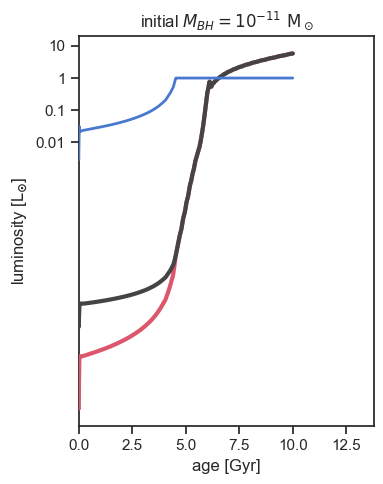

In [11]:
plt.figure(figsize=(4, 5))

#plt.plot(df['star_age']/1e9, 10**df['log_L'], lw=10, c='lightgray', zorder=-99, label=r'$L_\ast$')
#plt.plot(df['star_age']/1e9, 10**df['log_LH'], lw=3, c="#dc576c", label='fusion', zorder=99)#, c=cmap(norm(10**MBHf)))

for key, df in data.items():
    M, MBHf = key
    if M == 1.0 and MBHf==-11:
        plt.plot(df['star_age']/1e9, df['L_BH'], lw=3, c="#dc576c", label='accretion', zorder=99)#, c=cmap(norm(10**MBHf)))
        plt.plot(df['star_age']/1e9, df['L_E'], lw=3, c='#444444', label='Eddington', zorder=99)#, c=cmap(norm(10**MBHf)))
        plt.plot(df['star_age']/1e9, df['L_BH']/df['L_E'], lw=2, label='Accretion/Eddington', zorder=99)#, c=cmap(norm(10**MBHf)))

        plt.semilogy()
#plt.ylim([0.5e-2, 30])
        plt.gca().set_yticks([10**-2, 10**-1, 1, 10])
        plt.gca().set_yticklabels(['0.01', '0.1', '1', '10'])

        plt.title(r'initial $M_{BH} = 10^{-11}~\rm{M}_\odot$')
        plt.xlim([0, 13.8])#12.5])
        plt.xlabel('age [Gyr]')
        plt.ylabel(r'luminosity [L$_{\mathbf{\odot}}$]')
        plt.tight_layout()
        #plt.savefig('age-lum-11.pdf')
        plt.show()

2.9859835875279073
1.8590333790545015
2.9859835875279073
-1.1269502084734058
-0.9690518525429681
1.6342087262959995e-06
-6.0
-5.0
-4.0
-3.0
-2.0


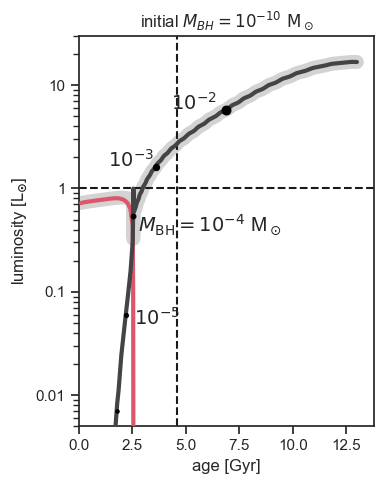

In [13]:
plt.figure(figsize=(4, 5))

norm = mpl.colors.LogNorm(vmin=10**-20, vmax=1)
cmap = plt.get_cmap('Reds')

for key, df in data.items():
    M, MBHf = key
    if M == 1.0 and MBHf==-10:
        df = df[df['center_h1'] < df['center_h1'].values[0]*0.995].reset_index()
        
        plt.plot(df['star_age']/1e9, 10**df['log_L'], lw=10, c='lightgray', zorder=-99, label=r'$L_\ast$')
        plt.plot(df['star_age']/1e9, 10**df['log_LH'], lw=3, c="#dc576c", label='fusion', zorder=99)#, c=cmap(norm(10**MBHf)))
        plt.plot(df['star_age']/1e9, df['L_BH'], lw=3, c='#444444', label='accretion', zorder=99)#, c=cmap(norm(10**MBHf)))
        
        print((df['star_age'][(df['L_BH']<=1).argmin()])/1e9)
        print((df['star_age'][(df['L_BH']<=0.01).argmin()])/1e9)
        print((df['star_age'][(df['L_BH']<=1).argmin()])/1e9)
        print((df['star_age'][(df['L_BH']<=0.01).argmin()] - df['star_age'][(df['L_BH']<=1).argmin()])/1e9)
        print((df['star_age'][(df['L_BH']<=1).argmin()])/1e9 - (df['star_age'][(df['L_BH']<=2).argmin()])/1e9)
        print(df['M_BH'][np.argmin(df['L_BH']<0.01)])
        
        LBH_func = interp1d(df['star_age']/1e9, df['L_BH'])
        MBH_func = interp1d(df['M_BH'], df['star_age']/1e9)
        masses = np.linspace(-6, -2, num=5)
        for mass in masses:
            print(mass)
            MBH_at_age = MBH_func(10**mass)
            L_BH_at_age = LBH_func(MBH_at_age)
            plt.plot(MBH_at_age, L_BH_at_age, 'o', c='#000000', zorder=99, ms=(15/-mass)**0.9)
            if mass != -4 and mass != -6 and mass != -1 and mass != -5:
                plt.text(0.98*MBH_at_age - (0.3 if mass == -2 else -0.1 if mass == -5 else 0), 
                         L_BH_at_age, r"$10^{"+str(int(mass))+"}$", ha='right', size=14,
                    zorder=9999999)
            elif mass == -4: 
                plt.text(MBH_at_age + 0.25, L_BH_at_age*0.7, 
                         r"$M_{\rm{BH}} = 10^{"+str(int(mass))+"}$ M$_\odot$", ha='left', size=14,
                    zorder=9999999)
            elif mass == -5:
                plt.text(MBH_at_age + 0.4, L_BH_at_age*0.8, 
                         r"$10^{"+str(int(mass))+"}$", ha='left', size=14,
                    zorder=9999999)

plt.axhline(10**0, ls='--', c='k')
plt.axvline(4.572, ls='--', c='k')

plt.semilogy()
plt.ylim([0.5e-2, 30])
plt.gca().set_yticks([10**-2, 10**-1, 1, 10])
plt.gca().set_yticklabels(['0.01', '0.1', '1', '10'])

plt.title(r'initial $M_{BH} = 10^{-10}~\rm{M}_\odot$')
plt.xlim([0, 13.8])#12.5])
plt.xlabel('age [Gyr]')
plt.ylabel(r'luminosity [L$_{\mathbf{\odot}}$]')


plt.tight_layout()
plt.savefig('age-lum-11.pdf')
plt.show()

<Figure size 500x500 with 0 Axes>

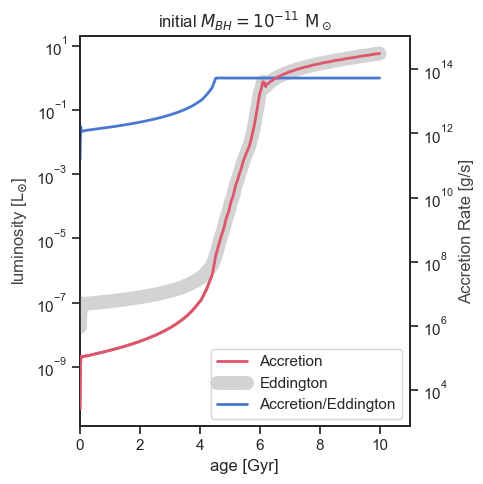

In [15]:
plt.figure(figsize=(5, 5))
fig, ax1 = plt.subplots(figsize=(5, 5))

#plt.plot(df['star_age']/1e9, 10**df['log_L'], lw=10, c='lightgray', zorder=-99, label=r'$L_\ast$')
#plt.plot(df['star_age']/1e9, 10**df['log_LH'], lw=3, c="#dc576c", label='fusion', zorder=99)#, c=cmap(norm(10**MBHf)))

for key, df in data.items():
    M, MBHf = key
    if M == 1.0 and MBHf==-11:
        ax1.plot(df['star_age']/1e9, df['L_BH'], lw=2, c="#dc576c", label='Accretion', zorder=99)#, c=cmap(norm(10**MBHf)))
        ax1.plot(df['star_age']/1e9, df['L_E'], lw=10, c='lightgray', label='Eddington', zorder=99)#, c=cmap(norm(10**MBHf)))
        ax1.plot(df['star_age']/1e9, df['L_BH']/df['L_E'], lw=2, label='Accretion/Eddington', zorder=99)#, c=cmap(norm(10**MBHf)))
        ax1.legend(loc='lower right')
        #plt.ylim([0.5e-2, 30])
        #plt.gca().set_yticks([10**-2, 10**-1, 1, 10])
        #plt.gca().set_yticklabels(['0.01', '0.1', '1', '10'])
        ax1.set_ylabel(r'luminosity [L$_{\mathbf{\odot}}$]', color="#444444")

        ax2 = ax1.twinx() 
        ax2.plot(df['star_age']/1e9, df['M_dot']*M_sun,c="#dc576c", lw=2, label='Accretion Rate', zorder=99)#, c=cmap(norm(10**MBHf)))

        ax1.set_xlabel('age [Gyr]')
        ax1.set_xlim([0, 11])
        ax1.semilogy()
        ax2.semilogy()
        ax2.set_ylabel(r'Accretion Rate [g/s]', color="#444444")

        plt.title(r'initial $M_{BH} = 10^{-11}~\rm{M}_\odot$')
        
        plt.tight_layout()
        plt.savefig('age-lum-11.pdf')
        plt.show()

<Figure size 600x500 with 0 Axes>

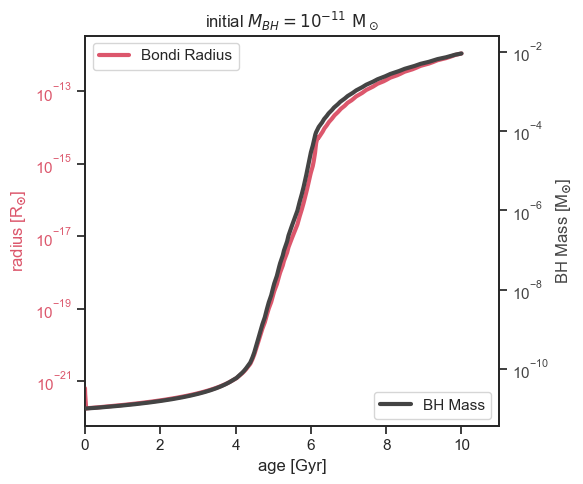

In [16]:
plt.figure(figsize=(6, 5))
fig, ax1 = plt.subplots(figsize=(6, 5))




#plt.plot(df['star_age']/1e9, 10**df['log_L'], lw=10, c='lightgray', zorder=-99, label=r'$L_\ast$')
#plt.plot(df['star_age']/1e9, 10**df['log_LH'], lw=3, c="#dc576c", label='fusion', zorder=99)#, c=cmap(norm(10**MBHf)))

for key, df in data.items():
    M, MBHf = key
    if M == 1.0 and MBHf == -11:
        ax1.plot(df['star_age'] / 1e9, df['R_B']/ R_sun , lw=3, c="#dc576c", label='Bondi Radius', zorder=99)
        ax1.set_ylabel(r'radius [R$_{\mathbf{\odot}}$]', color="#dc576c")
        ax1.tick_params(axis='y', labelcolor="#dc576c")
        plt.legend()
        
        # Secondary y-axis for BH Mass
        ax2 = ax1.twinx()  
        ax2.plot(df['star_age'] / 1e9, df['M_BH'] , lw=3, c='#444444', label='BH Mass', zorder=99)
        ax2.set_ylabel(r'BH Mass [M$_{\mathbf{\odot}}$]', color="#444444")
        ax2.tick_params(axis='y', labelcolor="#444444")
        plt.legend(loc='lower right')
        # Common x-axis settings
        ax1.set_xlabel('age [Gyr]')
        ax1.set_xlim([0, 11])
        ax1.semilogy()
        ax2.semilogy()
        plt.title(r'initial $M_{BH} = 10^{-11}~\rm{M}_\odot$')
        fig.tight_layout()
        plt.savefig('bondi-lum-11.pdf')
        
plt.show()


## Read Profiles at different Accretion Rates

In [17]:
#dirs = os.listdir('sep_pbh_grid/grid')
dirs = os.listdir('.')
dirs = [d for d in dirs if d.startswith('M=')]

print(dirs)

data = {}
for d in dirs:
    M, MBHf = d.split('_')
    M = float(M[2:])
    MBHf = float(MBHf[5:])
    file_path = os.path.join( d, 'LOGS', 'history.data')
    #file_path = os.path.join('pbh_grid', d, 'history.data')
    print(file_path)
    if not os.path.exists(file_path):
        continue
    df = pd.read_table(file_path, sep='\s+', skiprows=5)
    data[(M, MBHf)] = df[['star_age', 'log_L', 'log_Teff', 'center_h1', 'M_BH', 'log_LH', 'L_BH','L_E','R_B','cs_center','M_dot','log10(dm/dt)']]

data

['M=0.1_MBHf=-11', 'M=0.5_MBHf=-11', 'M=1.0_MBHf=-11', 'M=1.0_MBHf=-10']
M=0.1_MBHf=-11/LOGS/history.data
M=0.5_MBHf=-11/LOGS/history.data
M=1.0_MBHf=-11/LOGS/history.data
M=1.0_MBHf=-10/LOGS/history.data


{(0.1,
  -11.0):          star_age     log_L  log_Teff  center_h1          M_BH     log_LH  \
 0    1.000000e-05 -0.274424  3.450363   0.722545  1.000000e-10 -20.548326   
 1    1.004688e-05 -0.274424  3.450363   0.722545  1.000000e-10 -20.548326   
 2    1.004980e-05 -0.274424  3.450363   0.722545  1.000000e-10 -20.548326   
 3    1.005017e-05 -0.274424  3.450363   0.722545  1.000000e-10 -20.548326   
 4    1.005054e-05 -0.274424  3.450363   0.722545  1.000000e-10 -20.548326   
 ..            ...       ...       ...        ...           ...        ...   
 587  9.659173e+09 -2.949303  3.490670   0.719648  1.101386e-07  -2.977041   
 588  1.061618e+10 -2.938413  3.491722   0.719372  2.173452e-07  -2.992961   
 589  1.159006e+10 -2.918328  3.493595   0.719110  4.240892e-07  -3.024008   
 590  1.238577e+10 -2.884073  3.496643   0.718922  8.108927e-07  -3.080466   
 591  1.300000e+10 -2.830548  3.501037   0.718806  1.357705e-06  -3.176782   
 
              L_BH           L_E           R_B

In [18]:
dirs = os.listdir('.')
dirs = [d for d in dirs if d.startswith('M=')]
print(dirs)
d = 'M=1.0_MBHf=-11'
file_path_history = os.path.join( d, 'LOGS', 'history.data')
file_path_profile1 = os.path.join( d, 'LOGS', 'profile12_Lbh_div_L_0.001.data')
file_path_profile2 = os.path.join( d, 'LOGS', 'profile13_Lbh_div_L_0.01.data')
file_path_profile3 = os.path.join( d, 'LOGS', 'profile14_Lbh_div_L_0.1.data')
file_path_profile4 = os.path.join( d, 'LOGS', 'profile16_Lbh_div_L_1.data')


['M=0.1_MBHf=-11', 'M=0.5_MBHf=-11', 'M=1.0_MBHf=-11', 'M=1.0_MBHf=-10']


In [19]:
df = pd.read_table(file_path_profile1, sep='\s+', skiprows=5)
data = df[['zone','csound', 'logRho', 'mass', 'logR', 'logP', 'logT','opacity']]
data

,zone,csound,logRho,mass,logR,logP,logT,opacity
0,1,7.865261e+05,-6.595595,1.000000e+00,0.010596,4.980682,3.762728,0.427493
1,2,7.865496e+05,-6.595528,1.000000e+00,0.010596,4.980777,3.762756,0.427721
2,3,7.865783e+05,-6.595447,1.000000e+00,0.010596,4.980892,3.762790,0.427999
3,4,7.866112e+05,-6.595354,1.000000e+00,0.010596,4.981025,3.762829,0.428320
4,5,7.866484e+05,-6.595248,1.000000e+00,0.010596,4.981175,3.762873,0.428683
...,...,...,...,...,...,...,...,...
3665,3666,5.029231e+07,2.222365,3.051923e-10,-3.862879,17.403851,7.202663,1.161666
3666,3667,5.029232e+07,2.222365,1.525947e-10,-3.963223,17.403852,7.202663,1.161666
3667,3668,5.029232e+07,2.222365,7.629586e-11,-4.063567,17.403852,7.202663,1.161665
3668,3669,5.029232e+07,2.222365,3.814649e-11,-4.163912,17.403852,7.202663,1.161665


<Figure size 600x500 with 0 Axes>

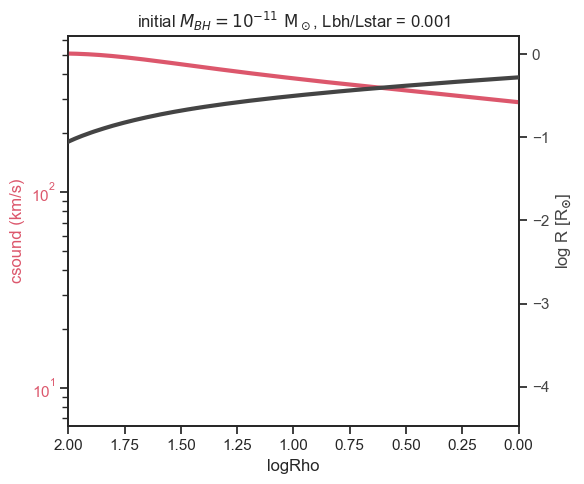

In [20]:
plt.figure(figsize=(6, 5))
fig, ax1 = plt.subplots(figsize=(6, 5))

#plt.plot(df['star_age']/1e9, 10**df['log_L'], lw=10, c='lightgray', zorder=-99, label=r'$L_\ast$')
#plt.plot(df['star_age']/1e9, 10**df['log_LH'], lw=3, c="#dc576c", label='fusion', zorder=99)#, c=cmap(norm(10**MBHf)))
ax1.plot(data['logRho'] , data['csound']/ 1e5 , lw=3, c="#dc576c", label='csound', zorder=99)
ax1.set_ylabel(r'csound (km/s)', color="#dc576c")
ax1.tick_params(axis='y', labelcolor="#dc576c")

# Secondary y-axis for BH Mass
ax2 = ax1.twinx()  
ax2.plot(data['logRho'] , data['logR'] , lw=3, c='#444444', label='logR', zorder=99)
ax2.set_ylabel(r'log R [R$_{\mathbf{\odot}}$]', color="#444444")
ax2.tick_params(axis='y', labelcolor="#444444")

# Common x-axis settings
ax1.set_xlabel('logRho')
ax1.set_xlim([2, 0])
ax2.set_xlim([2, 0])
ax1.semilogy()
#ax2.semilogy()
plt.title(r'initial $M_{BH} = 10^{-11}~\rm{M}_\odot$, Lbh/Lstar = 0.001')
fig.tight_layout()
        
plt.show()

In [21]:
df = pd.read_table(file_path_profile4, sep='\s+', skiprows=5)
data = df[['zone','csound', 'logRho', 'mass', 'logR', 'logP', 'logT','opacity']]
data

,zone,csound,logRho,mass,logR,logP,logT,opacity
0,1,7.410161e+05,-6.507057,9.999940e-01,0.017712,5.022013,3.715981,0.334695
1,2,7.410377e+05,-6.506998,9.999940e-01,0.017712,5.022094,3.716003,0.334770
2,3,7.410640e+05,-6.506926,9.999940e-01,0.017712,5.022192,3.716028,0.334861
3,4,7.410943e+05,-6.506843,9.999940e-01,0.017712,5.022305,3.716058,0.334965
4,5,7.411285e+05,-6.506749,9.999940e-01,0.017712,5.022433,3.716091,0.335084
...,...,...,...,...,...,...,...,...
3791,3792,4.815377e+07,1.736069,3.051923e-10,-3.676847,16.879913,7.102474,1.230245
3792,3793,4.815377e+07,1.736069,1.525956e-10,-3.756658,16.879913,7.102474,1.230245
3793,3794,4.815377e+07,1.736069,7.629723e-11,-3.823032,16.879913,7.102474,1.230245
3794,3795,4.815377e+07,1.736069,3.814809e-11,-3.872785,16.879913,7.102474,1.230245


<Figure size 600x500 with 0 Axes>

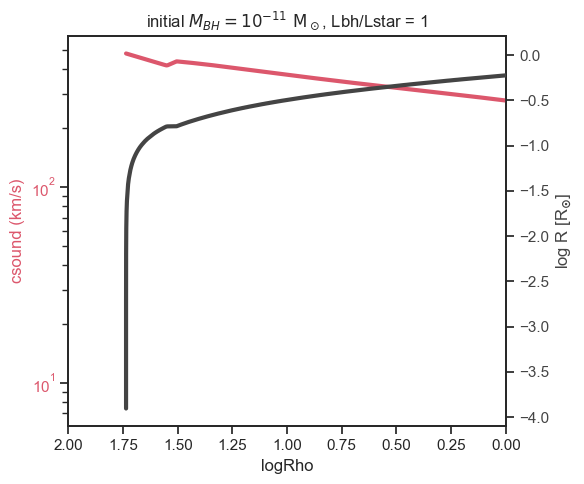

In [22]:
plt.figure(figsize=(6, 5))
fig, ax1 = plt.subplots(figsize=(6, 5))

#plt.plot(df['star_age']/1e9, 10**df['log_L'], lw=10, c='lightgray', zorder=-99, label=r'$L_\ast$')
#plt.plot(df['star_age']/1e9, 10**df['log_LH'], lw=3, c="#dc576c", label='fusion', zorder=99)#, c=cmap(norm(10**MBHf)))
ax1.plot(data['logRho'] , data['csound']/ 1e5 , lw=3, c="#dc576c", label='csound', zorder=99)
ax1.set_ylabel(r'csound (km/s)', color="#dc576c")
ax1.tick_params(axis='y', labelcolor="#dc576c")

# Secondary y-axis for BH Mass
ax2 = ax1.twinx()  
ax2.plot(data['logRho'] , data['logR'] , lw=3, c='#444444', label='logR', zorder=99)
ax2.set_ylabel(r'log R [R$_{\mathbf{\odot}}$]', color="#444444")
ax2.tick_params(axis='y', labelcolor="#444444")

# Common x-axis settings
ax1.set_xlabel('logRho')
#ax1.set_xlim([0, 13.8])
ax1.semilogy()
#ax2.semilogy()
ax1.set_xlim([2, 0])
ax2.set_xlim([2, 0])
plt.title(r'initial $M_{BH} = 10^{-11}~\rm{M}_\odot$, Lbh/Lstar = 1')
fig.tight_layout()
        
plt.show()

Initial PBH Mass: 10E-11
MESA Profile at: 

Star Age 5.2856E+09
M_BH/M_sun:    1.2316982324578940E-007
L_BH/L_sun:    1.0801241901924326E-003

L_BH is limited by Ledd at this point


In [26]:
dirs = os.listdir('.')
dirs = [d for d in dirs if d.startswith('M=')]
print(dirs)
d = 'rotating/M=1.0_MBHf=-11_wk0.2'
file_path_history = os.path.join( d, 'LOGS', 'history.data')
file_path_profile1 = os.path.join( d, 'LOGS', 'profile3_Lbh_div_L_0.001.data')
file_path_profile2 = os.path.join( d, 'LOGS', 'profile4_Lbh_div_L_0.01.data')
file_path_profile3 = os.path.join( d, 'LOGS', 'profile5_Lbh_div_L_0.1.data')
file_path_profile4 = os.path.join( d, 'LOGS', 'profile6_Lbh_div_L_1.data')

['M=0.1_MBHf=-11', 'M=0.5_MBHf=-11', 'M=1.0_MBHf=-11', 'M=1.0_MBHf=-10']


In [27]:
df = pd.read_table(file_path_profile1, sep='\s+', skiprows=5)
data = df[['zone','csound', 'logRho', 'mass', 'logR', 'logP', 'logT','opacity','j_rot','dynamo_log_B_r','dynamo_log_B_phi']]

<Figure size 600x500 with 0 Axes>

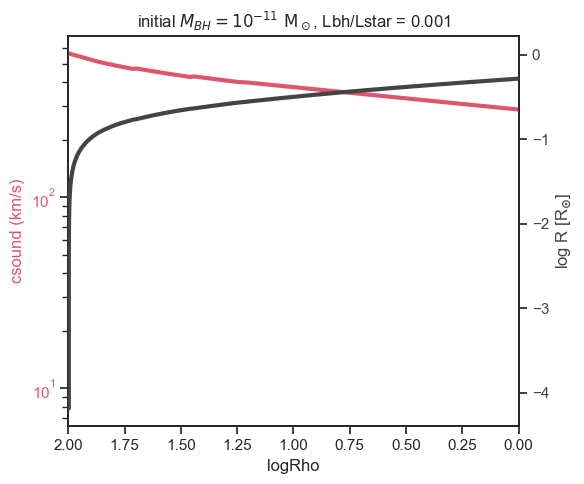

In [29]:
plt.figure(figsize=(6, 5))
fig, ax1 = plt.subplots(figsize=(6, 5))

#plt.plot(df['star_age']/1e9, 10**df['log_L'], lw=10, c='lightgray', zorder=-99, label=r'$L_\ast$')
#plt.plot(df['star_age']/1e9, 10**df['log_LH'], lw=3, c="#dc576c", label='fusion', zorder=99)#, c=cmap(norm(10**MBHf)))
ax1.plot(data['logRho'] , data['csound']/ 1e5 , lw=3, c="#dc576c", label='csound', zorder=99)
ax1.set_ylabel(r'csound (km/s)', color="#dc576c")
ax1.tick_params(axis='y', labelcolor="#dc576c")

# Secondary y-axis for BH Mass
ax2 = ax1.twinx()  
ax2.plot(data['logRho'] , data['logR'] , lw=3, c='#444444', label='logR', zorder=99)
ax2.set_ylabel(r'log R [R$_{\mathbf{\odot}}$]', color="#444444")
ax2.tick_params(axis='y', labelcolor="#444444")

# Common x-axis settings
ax1.set_xlabel('logRho')
ax1.set_xlim([2, 0])
ax2.set_xlim([2, 0])
ax1.semilogy()
#ax2.semilogy()
plt.title(r'initial $M_{BH} = 10^{-11}~\rm{M}_\odot$, Lbh/Lstar = 0.001')
fig.tight_layout()
        
plt.show()


<Figure size 600x500 with 0 Axes>

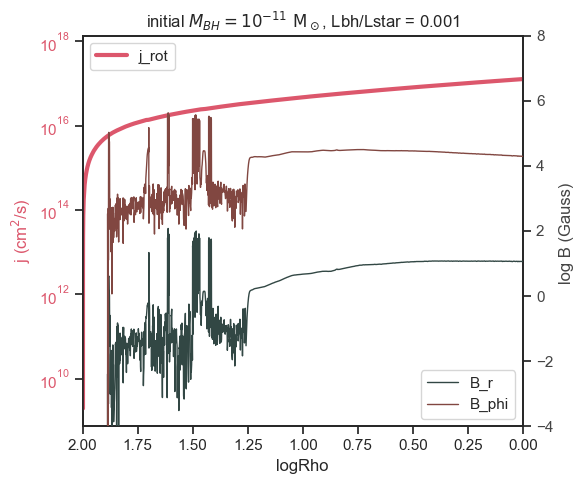

In [30]:
plt.figure(figsize=(6, 5))
fig, ax1 = plt.subplots(figsize=(6, 5))

#plt.plot(df['star_age']/1e9, 10**df['log_L'], lw=10, c='lightgray', zorder=-99, label=r'$L_\ast$')
#plt.plot(df['star_age']/1e9, 10**df['log_LH'], lw=3, c="#dc576c", label='fusion', zorder=99)#, c=cmap(norm(10**MBHf)))
ax1.plot(data['logRho'] , data['j_rot'] , lw=3, c="#dc576c", label='j_rot', zorder=99)
ax1.set_ylabel(r'j (cm$^2$/s)', color="#dc576c")
plt.legend(loc='upper left')
ax1.tick_params(axis='y', labelcolor="#dc576c")

# Secondary y-axis for BH Mass
ax2 = ax1.twinx()  
ax2.plot(data['logRho'] , data['dynamo_log_B_r'] , lw=1, c='#324744', label='B_r', zorder=99)
ax2.plot(data['logRho'] , data['dynamo_log_B_phi'] , lw=1, c='#814741', label='B_phi', zorder=99)
plt.legend(loc='lower right')
ax2.set_ylabel(r'log B (Gauss) ', color="#444444")
ax2.tick_params(axis='y', labelcolor="#444444")

# Common x-axis settings
ax1.set_xlabel('logRho')
ax1.set_xlim([2, 0])
ax2.set_xlim([2, 0])
ax2.set_ylim([-4, 8])
ax1.semilogy()
#ax2.semilogy()

plt.title(r'initial $M_{BH} = 10^{-11}~\rm{M}_\odot$, Lbh/Lstar = 0.001')
fig.tight_layout()
plt.savefig('rotation_and_bfields.pdf')
     
plt.show()


<Figure size 600x500 with 0 Axes>

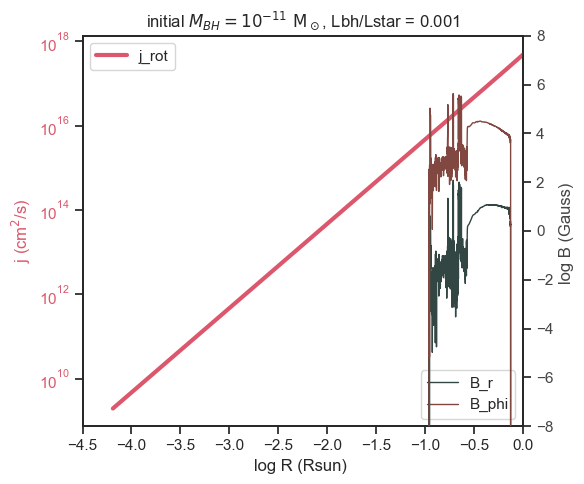

In [31]:
plt.figure(figsize=(6, 5))
fig, ax1 = plt.subplots(figsize=(6, 5))

#plt.plot(df['star_age']/1e9, 10**df['log_L'], lw=10, c='lightgray', zorder=-99, label=r'$L_\ast$')
#plt.plot(df['star_age']/1e9, 10**df['log_LH'], lw=3, c="#dc576c", label='fusion', zorder=99)#, c=cmap(norm(10**MBHf)))
ax1.plot(data['logR'] , data['j_rot'] , lw=3, c="#dc576c", label='j_rot', zorder=99)
ax1.set_ylabel(r'j (cm$^2$/s)', color="#dc576c")
plt.legend(loc='upper left')
ax1.tick_params(axis='y', labelcolor="#dc576c")

# Secondary y-axis for BH Mass
ax2 = ax1.twinx()  
ax2.plot(data['logR'] , data['dynamo_log_B_r'] , lw=1, c='#324744', label='B_r', zorder=99)
ax2.plot(data['logR'] , data['dynamo_log_B_phi'] , lw=1, c='#814741', label='B_phi', zorder=99)
plt.legend(loc='lower right')
ax2.set_ylabel(r'log B (Gauss) ', color="#444444")
ax2.tick_params(axis='y', labelcolor="#444444")

# Common x-axis settings
ax1.set_xlabel(r'log R (Rsun) ')
ax1.set_xlim([-4.5, 0])
ax2.set_xlim([-4.5, 0])
ax2.set_ylim([-8, 8])
ax1.semilogy()
#ax2.semilogy()

plt.title(r'initial $M_{BH} = 10^{-11}~\rm{M}_\odot$, Lbh/Lstar = 0.001')
fig.tight_layout()
plt.savefig('rotation_and_bfields.pdf')
     
plt.show()


In [32]:
df = pd.read_table(file_path_history, sep='\s+', skiprows=5)
dh = df[['star_age', 'log_L', 'log_Teff', 'center_h1', 'M_BH', 'log_LH', 'L_BH','L_E','R_B','cs_center','M_dot','log10(dm/dt)','surf_avg_v_rot','cs_center']]

<Figure size 600x500 with 0 Axes>

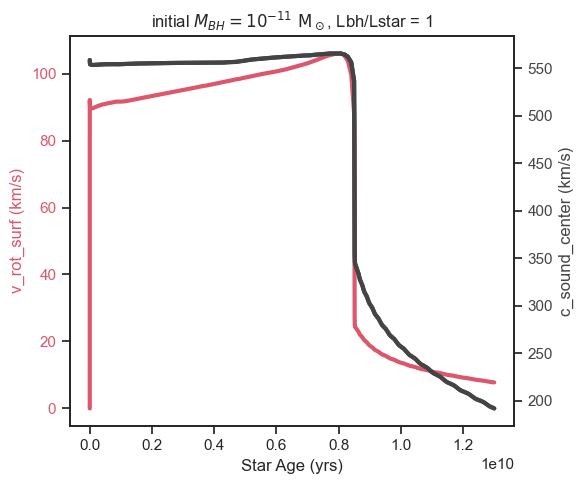

In [33]:
plt.figure(figsize=(6, 5))
fig, ax1 = plt.subplots(figsize=(6, 5))

#plt.plot(df['star_age']/1e9, 10**df['log_L'], lw=10, c='lightgray', zorder=-99, label=r'$L_\ast$')
#plt.plot(df['star_age']/1e9, 10**df['log_LH'], lw=3, c="#dc576c", label='fusion', zorder=99)#, c=cmap(norm(10**MBHf)))
ax1.plot(dh['star_age'] , dh['surf_avg_v_rot'] , lw=3, c="#dc576c", label='v_rot', zorder=99)
ax1.set_ylabel(r'v_rot_surf (km/s)', color="#dc576c")
ax1.tick_params(axis='y', labelcolor="#dc576c")

# Secondary y-axis for BH Mass
ax2 = ax1.twinx()  
ax2.plot(dh['star_age'] , dh['cs_center']/ 1e5 , lw=3, c='#444444', label='cs_center', zorder=99)
#ax2.plot(dh['star_age'] , dh['L_BH']/ dh['L_E'] , lw=3, c='#444444', label='cs_center', zorder=99)
ax2.set_ylabel(r'c_sound_center (km/s)', color="#444444")
ax2.tick_params(axis='y', labelcolor="#444444")

# Common x-axis settings
ax1.set_xlabel('Star Age (yrs)')
#ax1.set_xlim([0, 13.8])
#ax1.semilogy()
#ax2.semilogy()
#ax1.set_xlim([2, 0])
#ax2.set_xlim([2, 0])
plt.title(r'initial $M_{BH} = 10^{-11}~\rm{M}_\odot$, Lbh/Lstar = 1')
fig.tight_layout()
        
plt.show()

<Figure size 600x500 with 0 Axes>

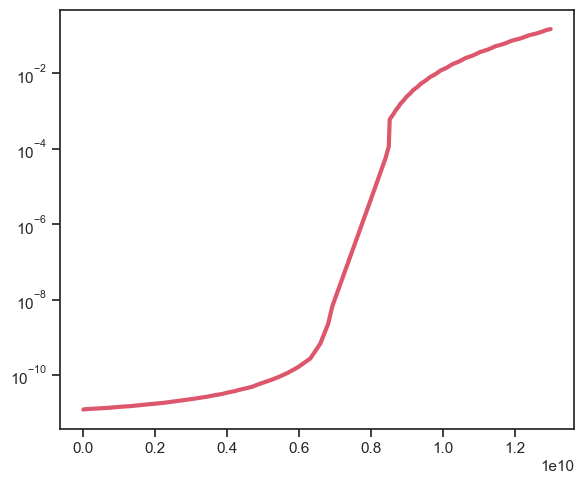

In [34]:
plt.figure(figsize=(6, 5))
fig, ax1 = plt.subplots(figsize=(6, 5))

#plt.plot(df['star_age']/1e9, 10**df['log_L'], lw=10, c='lightgray', zorder=-99, label=r'$L_\ast$')
#plt.plot(df['star_age']/1e9, 10**df['log_LH'], lw=3, c="#dc576c", label='fusion', zorder=99)#, c=cmap(norm(10**MBHf)))
ax1.plot(dh['star_age'] , dh['R_B'] , lw=3, c="#dc576c", label='v_rot', zorder=99)
ax1.semilogy()
fig.tight_layout()
        
plt.show()

<Figure size 600x500 with 0 Axes>

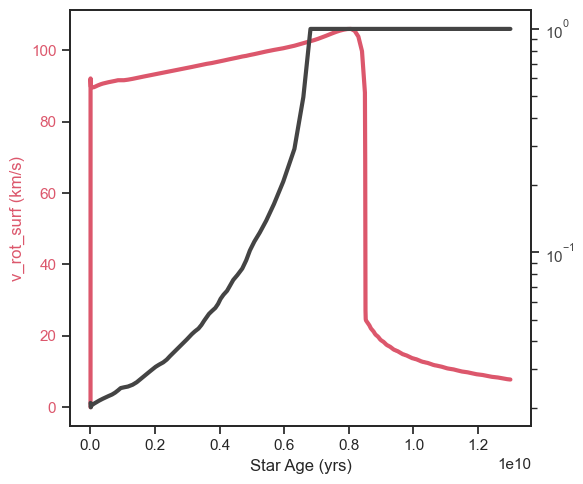

In [35]:
plt.figure(figsize=(6, 5))
fig, ax1 = plt.subplots(figsize=(6, 5))

#plt.plot(df['star_age']/1e9, 10**df['log_L'], lw=10, c='lightgray', zorder=-99, label=r'$L_\ast$')
#plt.plot(df['star_age']/1e9, 10**df['log_LH'], lw=3, c="#dc576c", label='fusion', zorder=99)#, c=cmap(norm(10**MBHf)))
ax1.plot(dh['star_age'] , dh['surf_avg_v_rot'] , lw=3, c="#dc576c", label='v_rot', zorder=99)
ax1.set_ylabel(r'v_rot_surf (km/s)', color="#dc576c")
ax1.tick_params(axis='y', labelcolor="#dc576c")

# Secondary y-axis for BH Mass
ax2 = ax1.twinx()  
#ax2.plot(dh['star_age'] , dh['cs_center']/ 1e5 , lw=3, c='#444444', label='cs_center', zorder=99)
ax2.plot(dh['star_age'] , dh['L_BH']/ dh['L_E'] , lw=3, c='#444444', label='cs_center', zorder=99)
#ax2.set_ylabel(r'c_sound_center (km/s)', color="#444444")
ax2.tick_params(axis='y', labelcolor="#444444")

# Common x-axis settings
ax1.set_xlabel('Star Age (yrs)')
#ax1.set_xlim([0, 13.8])
#ax1.semilogy()
ax2.semilogy()
#ax1.set_xlim([2, 0])
#ax2.set_xlim([2, 0])
#plt.title(r'initial $M_{BH} = 10^{-11}~\rm{M}_\odot$, Lbh/Lstar = 1')
fig.tight_layout()
        
plt.show()

### TO DO:
- Extrapolate density, cs and other quantities to small radial coordinates (down to Rs)
- Calculate relevant radii (Rs, Rlso, Rb, Rinf)
- Calculate free fall timescale as function of r
- Calculate resulting mdot 
- Calculate Bondi accretion rate
- Calculate Eddington Limited accretion rate

In [40]:
dirs = os.listdir('.')
dirs = [d for d in dirs if d.startswith('M=')]
print(dirs)
d = 'rotating/M=1.0_MBHf=-11_wk0.2'
file_path_history = os.path.join( d, 'LOGS', 'history.data')
file_path_profile1 = os.path.join( d, 'LOGS', 'profile3_Lbh_div_L_0.001.data')
file_path_profile2 = os.path.join( d, 'LOGS', 'profile4_Lbh_div_L_0.01.data')
file_path_profile3 = os.path.join( d, 'LOGS', 'profile5_Lbh_div_L_0.1.data')
file_path_profile4 = os.path.join( d, 'LOGS', 'profile6_Lbh_div_L_1.data')

['M=0.1_MBHf=-11', 'M=0.5_MBHf=-11', 'M=1.0_MBHf=-11', 'M=1.0_MBHf=-10']


In [41]:
df = pd.read_table(file_path_profile1, sep='\s+', skiprows=5)
data = df[['zone','csound', 'logRho', 'mass', 'logR', 'logP', 'logT','opacity','j_rot','dynamo_log_B_r','dynamo_log_B_phi']]

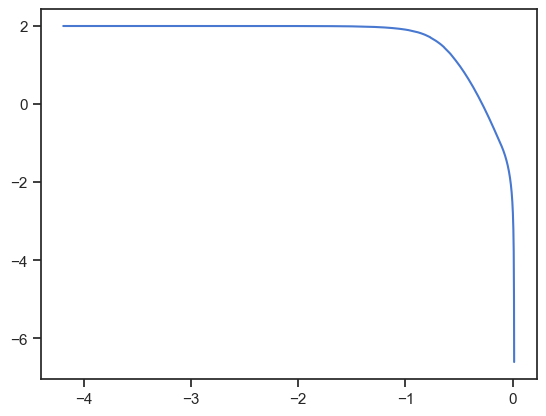

In [42]:
#plt.plot(data['zone'],data['csound'])
plt.plot(data['logR'],data['logRho'])

Spherical Star. PBH region is so small we can approximate ~constant density rho. So enclosed mass is m = 4/3 pi r^3 rho[center]


In [43]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_enclosed_mass(data, r_min=None, n_points=1000):
    """
    Calculate enclosed mass profile with extrapolation to small radii,
    assuming constant central density for r < r_min.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing 'logR' (log10 of radius in cm)
        and 'logRho' (log10 of density in g/cm³)
        Data should be ordered from surface to center
    r_min : float, optional
        Minimum radius for extrapolation in cm
        If None, will use an order of magnitude smaller than minimum R
    n_points : int, optional
        Number of points in the extrapolated region
        
    Returns:
    --------
    dict
        Dictionary containing arrays of:
        - radius: Array of radii including extrapolated region (cm)
        - enclosed_mass: Corresponding enclosed mass (g)
        - density: Corresponding density profile (g/cm³)
        - is_extrapolated: Boolean mask indicating extrapolated points
    """
    # Convert logarithmic quantities to linear
    Msun = 1.989e33
    Rsun = 6.955e10
    
    R = Rsun*10**data['logR'].values        # radius in Rsun
    rho = 10**data['logRho'].values    # density in g/cm³
    mass = Msun*data['mass'].values         # mass in Msun
    
    # Get central values (last points in arrays since data is surface to center)
    R_center = R[-1]
    rho_center = rho[-1]
    
    # Set up extrapolation range if needed
    if r_min is None:
        r_min = R_center / 1e13
    
    # Create extended radius array for inner region
    r_inner = np.logspace(np.log10(r_min), np.log10(R_center), n_points)
    
    # Calculate enclosed mass for inner region assuming constant central density
    # M(r) = 4/3 π r³ ρ_center for r < R_center
    m_inner = 4.0/3.0 * np.pi * r_inner**3 * rho_center

    # Combine arrays
    # Note: We reverse the original arrays since we want to go from center outward
    radius_full = np.concatenate([r_inner[:-1], R[::-1]])
    mass_full = np.concatenate([m_inner[:-1], mass[::-1]])
    density_full = np.concatenate([np.full_like(r_inner[:-1], rho_center), rho[::-1]])
    
    # Create mask for extrapolated points
    is_extrapolated = np.concatenate([np.ones_like(r_inner[:-1], dtype=bool), 
                                    np.zeros_like(R, dtype=bool)])
    
    
    # Ensure mass is monotonically increasing
    mass_full = np.maximum.accumulate(mass_full)
    
    # Create results dictionary
    results = {
        'radius': radius_full,
        'enclosed_mass': mass_full,
        'density': density_full,
        'is_extrapolated': is_extrapolated,
        # Store original data for reference
        'radius_original': R[::-1],
        'mass_original': mass[::-1],
        'density_original': rho[::-1]
    }
    
    return results

def validate_mass_profile(results):
    """
    Validate the mass profile by checking physical constraints.
    
    Parameters:
    -----------
    results : dict
        Output from calculate_enclosed_mass
        
    Returns:
    --------
    dict
        Dictionary containing validation results
    """
    validation = {
        'is_monotonic': np.all(np.diff(results['enclosed_mass']) >= 0),
        'density_continuity': np.abs(results['density'][results['is_extrapolated']][-1] - 
                                   results['density'][~results['is_extrapolated']][0]) < 1e-10,
        'mass_continuity': np.abs(results['enclosed_mass'][results['is_extrapolated']][-1] - 
                                results['enclosed_mass'][~results['is_extrapolated']][0]) < 1e-10
    }
    
    return validation

def analyze_mass_profile(results):
    """
    Analyze the enclosed mass profile.
    
    Parameters:
    -----------
    results : dict
        Output from calculate_enclosed_mass
        
    Returns:
    --------
    dict
        Dictionary containing analysis results
    """
    # Calculate mass profile properties
    analysis = {
        'total_mass': results['enclosed_mass'][-1],
        'central_density': results['density'][0],
        'surface_density': results['density'][-1],
        'central_mass': results['enclosed_mass'][0],
        'mass_ratio_extrapolated': (results['enclosed_mass'][results['is_extrapolated']][-1] / 
                                  results['enclosed_mass'][-1])
    }
    
    return analysis

def plot_stellar_structure(results, fig_size=(15, 10)):
    """
    Create comprehensive visualization of the stellar structure.
    
    Parameters:
    -----------
    results : dict
        Output from calculate_enclosed_mass
    fig_size : tuple
        Figure size in inches
        
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure object
    """
    fig = plt.figure(figsize=fig_size)
    gs = plt.GridSpec(2, 2, figure=fig)
    
    # 1. Enclosed Mass Profile
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.loglog(results['radius'], results['enclosed_mass'], 'b-', label='Full Profile')
    ax1.loglog(results['radius_original'], results['mass_original'], 'r.', 
               label='Original Data', markersize=4)
    
    # Highlight extrapolated region
    extrapolated_mask = results['is_extrapolated']
    ax1.loglog(results['radius'][extrapolated_mask], 
               results['enclosed_mass'][extrapolated_mask], 
               'g--', label='Extrapolated')
    
    ax1.set_xlabel('Radius (cm)')
    ax1.set_ylabel('Enclosed Mass (g)')
    ax1.legend()
    ax1.grid(True)
    ax1.set_title('Enclosed Mass Profile')
    
    # 2. Density Profile
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.loglog(results['radius'], results['density'], 'b-', label='Full Profile')
    ax2.loglog(results['radius_original'], results['density_original'], 'r.', 
               label='Original Data', markersize=4)
    
    # Highlight extrapolated region
    ax2.loglog(results['radius'][extrapolated_mask], 
               results['density'][extrapolated_mask], 
               'g--', label='Extrapolated')
    
    ax2.set_xlabel('Radius (cm)')
    ax2.set_ylabel('Density (g/cm³)')
    ax2.legend()
    ax2.grid(True)
    ax2.set_title('Density Profile')
    
    # 3. Mass Gradient (dM/dr)
    ax3 = fig.add_subplot(gs[1, 0])
    dr = np.gradient(results['radius'])
    dm = np.gradient(results['enclosed_mass'])
    mass_gradient = dm/dr
    
    ax3.loglog(results['radius'], mass_gradient, 'b-', label='Full Profile')
    ax3.loglog(results['radius'][extrapolated_mask], 
               mass_gradient[extrapolated_mask], 
               'g--', label='Extrapolated')
    
    ax3.set_xlabel('Radius (cm)')
    ax3.set_ylabel('dM/dr')
    ax3.legend()
    ax3.grid(True)
    ax3.set_title('Mass Gradient')
    
    # 4. Mass Fraction
    ax4 = fig.add_subplot(gs[1, 1])
    mass_fraction = results['enclosed_mass'] / results['enclosed_mass'][-1]
    
    ax4.loglog(results['radius'], mass_fraction, 'b-', label='Full Profile')
    ax4.loglog(results['radius_original'], 
                 results['mass_original']/results['enclosed_mass'][-1], 
                 'r.', label='Original Data', markersize=4)
    
    ax4.set_xlabel('Radius (cm)')
    ax4.set_ylabel('Mass Fraction (M(r)/M_total)')
    ax4.legend()
    ax4.grid(True)
    ax4.set_title('Mass Fraction Profile')
    
    plt.tight_layout()
    return fig

def plot_extrapolation_detail(results):
    """
    Create detailed view of the extrapolation region.
    
    Parameters:
    -----------
    results : dict
        Output from calculate_enclosed_mass
        
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure object
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Find transition point
    transition_idx = np.where(~results['is_extrapolated'])[0][0]
    transition_r = results['radius'][transition_idx]
    
    # Plot region around transition
    window = slice(max(0, transition_idx - 1000), min(len(results['radius']), transition_idx + 1000))
    
    ax.loglog(results['radius'][window], results['enclosed_mass'][window], 'b-', label='Full Profile')
    ax.loglog(results['radius_original'], results['mass_original'], 'r.', 
              label='Original Data', markersize=4)
    
    # Highlight extrapolated region
    extrapolated_mask = results['is_extrapolated'][window]
    ax.loglog(results['radius'][window][extrapolated_mask], 
              results['enclosed_mass'][window][extrapolated_mask], 
              'g--', label='Extrapolated')
    
    # Add vertical line at transition
    ax.axvline(transition_r, color='k', linestyle=':', label='Transition Point')
    
    ax.set_xlabel('Radius (cm)')
    ax.set_ylabel('Enclosed Mass (g)')
    ax.legend()
    ax.grid(True)
    ax.set_title('Detail of Extrapolation Region')
    
    return fig

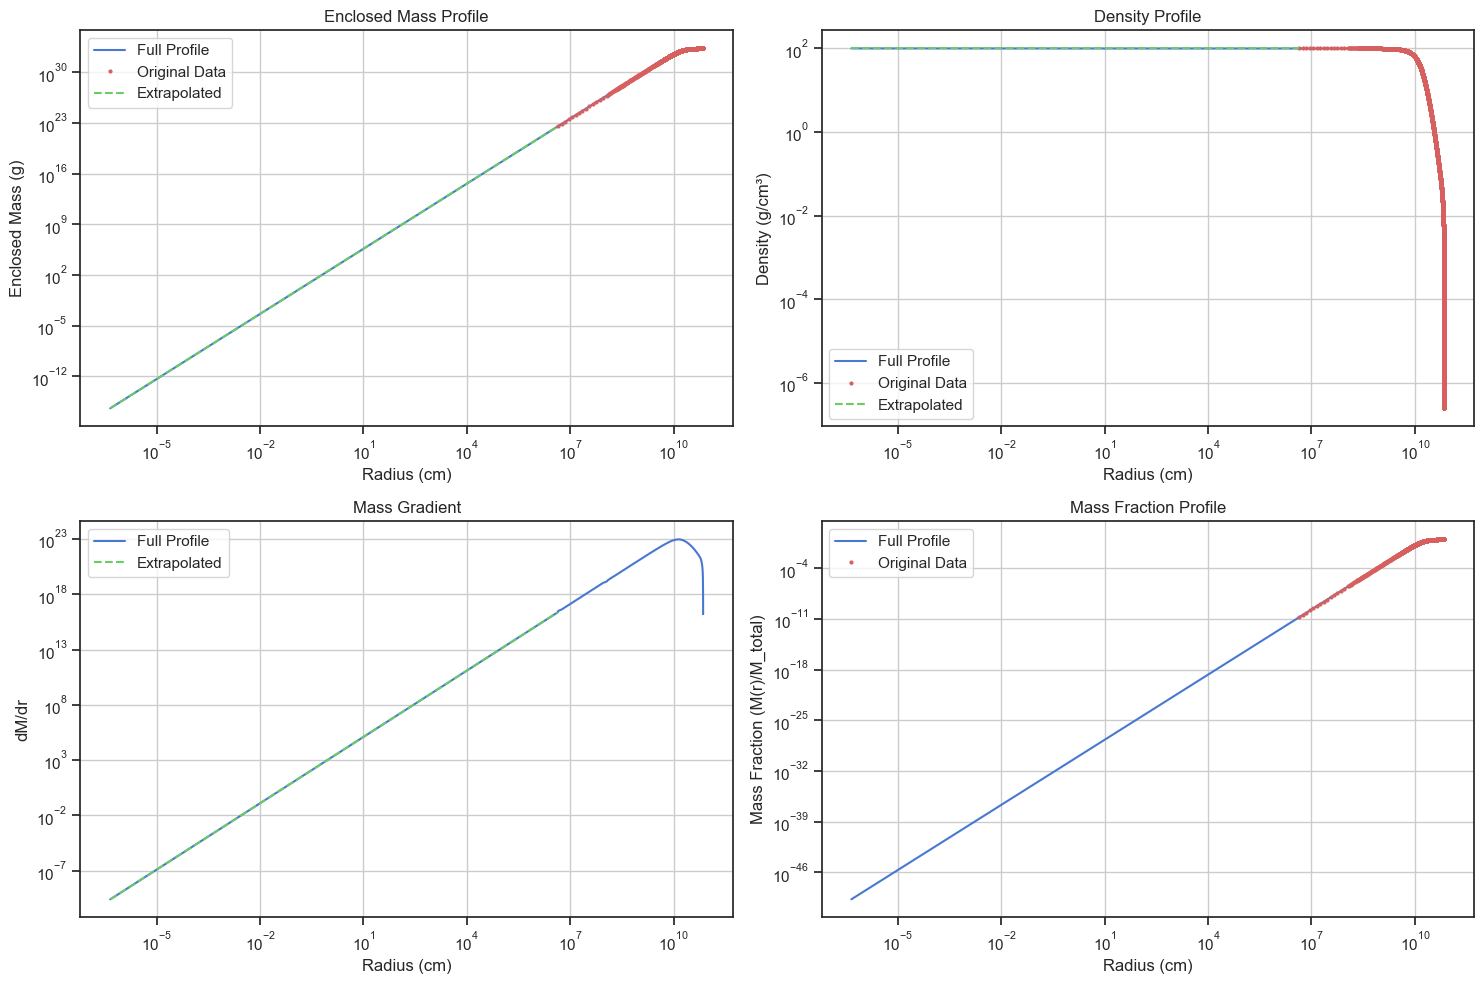

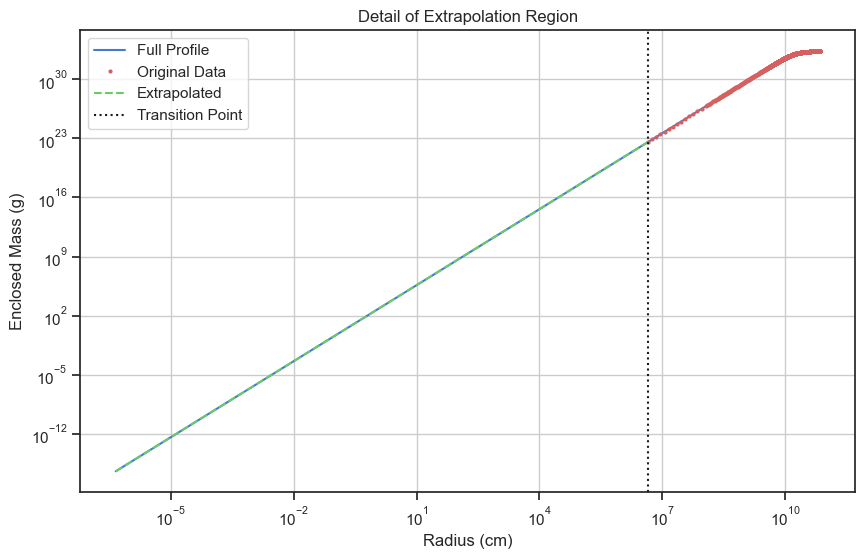

In [44]:
# Calculate enclosed mass profile
results = calculate_enclosed_mass(data)

# Create main visualization
fig_main = plot_stellar_structure(results)

# Create detailed view of extrapolation region
fig_detail = plot_extrapolation_detail(results)

# If you want to save the figures
fig_main.savefig('stellar_structure.png', dpi=300, bbox_inches='tight')
fig_detail.savefig('extrapolation_detail.png', dpi=300, bbox_inches='tight')

In [45]:
def calculate_freefall_timescale(enclosed_mass,radius):
    
    """
    Calculate the free fall timescale as a function of radial coordinate.
    
    Parameters:
    -----------
    enclosed_mass
    radius
        
    Returns:
    --------
    numpy.ndarray
        Free fall timescale in seconds
     """    
    # Gravitational constant in cgs units (cm³ g⁻¹ s⁻²)
    
    G = 6.67e-8
    
    # Ensure no division by zero or negative values
    valid_mass = np.maximum(enclosed_mass, 1e-100)  # Avoid division by zero
    
    # t_ff(R) = π sqrt(R³/(8GM(R)))
    tau_ff = np.pi * np.sqrt(radius**3 / (8.0 * G * valid_mass))
    
    return tau_ff

In [46]:
# Calculate enclosed mass M(R)
# Extrapolate to arbitrarily small values of R 
# Calculate free fall timescale as t_ff(R) = \pi \sqrt{R^3/(8 G M(R)} 

In [47]:
results = calculate_enclosed_mass(data)


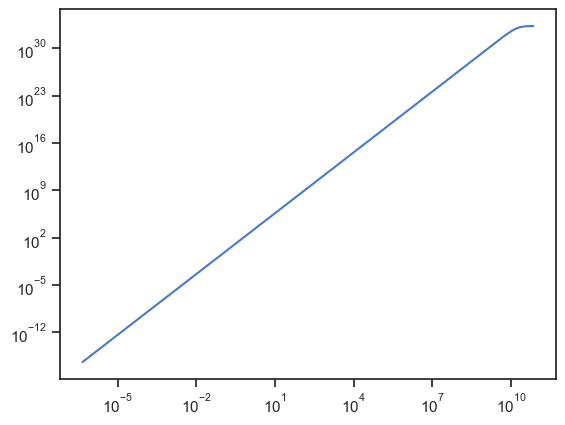

In [48]:
plt.loglog(results['radius'], results['enclosed_mass'])

In [49]:
tff = calculate_freefall_timescale(results['enclosed_mass'],results['radius'])

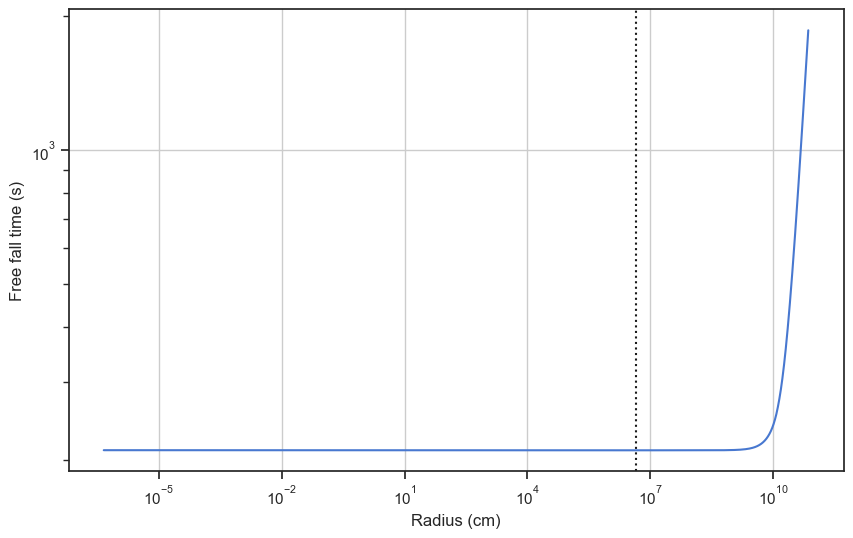

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))
  # Find transition point
transition_idx = np.where(~results['is_extrapolated'])[0][0]
transition_r = results['radius'][transition_idx]
ax.loglog(results['radius'], tff)
ax.axvline(transition_r, color='k', linestyle=':', label='Transition Point')
ax.set_xlabel('Radius (cm)')
ax.set_ylabel('Free fall time (s)')
ax.grid(True)

In [53]:
#Rs, Rlso, Rb, Rinf
Msun  = 1.989e33
Rsun  = 6.955e10
G     = 6.67e-8
c     = 2.99792458e10
mp    = 1.6749e-24 # g
sigma = 6.6524e-25 #cm^2

Mpbh = 1e-11*Msun 

In [54]:
Rs = 2.0*G*Mpbh/c**2.0
#Rb = 2.0*G*Mpbh/cs**2.0
Rb = 2.0*G*Mpbh/data['csound'].iloc[-1]**2.0
#help(data['csound'])
print(Rs)
print(Rb)

2.9522233226285226e-06
0.8312442889676315


In [55]:
from scipy import interpolate

# Create interpolation function
mass_to_radius = interpolate.interp1d(results['enclosed_mass'], results['radius'])
mass_to_tff = interpolate.interp1d(results['enclosed_mass'],tff)
radius_to_density = interpolate.interp1d(results['radius'],results['density'])
#radius_to_cs = interpolate.interp1d(results['radius'],data['csound'])

# Find Rinf where enclosed_mass = Mpbh
Rinf = mass_to_radius(Mpbh)
tff_inf = mass_to_tff(Mpbh)
density_rb = radius_to_density(Rb)
#csound_rb = radius_to_cs(Rb)
print(Rinf)
print(tff_inf)
print(density_rb)
#print(csound_rb)

3626684.3261561715
210.65528797590423
99.50630144331575


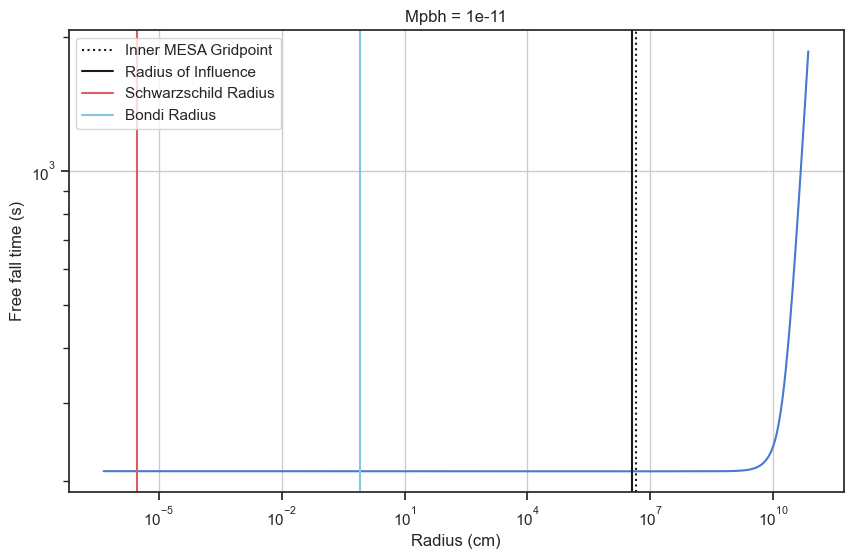

In [56]:
pbhmass = str(Mpbh/Msun)
fig, ax = plt.subplots(figsize=(10, 6))
  # Find transition point
transition_idx = np.where(~results['is_extrapolated'])[0][0]
transition_r = results['radius'][transition_idx]
ax.loglog(results['radius'], tff)
ax.axvline(transition_r, color='k', linestyle=':', label='Inner MESA Gridpoint')
ax.axvline(Rinf, color='k', linestyle='-', label='Radius of Influence')
ax.axvline(Rs, color='r', linestyle='-', label='Schwarzschild Radius')
ax.axvline(Rb, color='c', linestyle='-', label='Bondi Radius')
ax.set_xlabel('Radius (cm)')
ax.set_ylabel('Free fall time (s)')
ax.set_title(str('Mpbh = ')+pbhmass)

plt.legend()
ax.grid(True)

### Find Bondi Accretion Rate, M_inf/t_ff, Eddington Limited Accretion Rate

In [57]:

Mdot_edd= 4.0*np.pi*mp*c*Rs/sigma
print(Mdot_edd)
Mdot_bondi= 4.0*np.pi*Rb**2.0*density_rb*data['csound'].iloc[-1] # Fix this with csound interpolation
print(Mdot_bondi)
Mdot_ff= Mpbh/tff_inf
print(Mdot_ff)

2800208.061027208
48814491133.379845
9.441965682947922e+19


In [58]:
print(Mdot_ff/Mdot_edd)

33718800450436.176


In [59]:
print(Mdot_ff/Mdot_bondi)
print(Mdot_ff/Msun)

1934254657.5255418
4.747091846630428e-14


In [60]:
print(data['csound'].iloc[-1]/1e5)

564.9772613243962


In [61]:
Mpbh = 1e-5*Msun

In [62]:
# Find Rinf where enclosed_mass = Mpbh
Rinf = mass_to_radius(Mpbh)
tff_inf = mass_to_tff(Mpbh)
density_rb = radius_to_density(Rb)
#csound_rb = radius_to_cs(Rb)
print(Rinf)
print(tff_inf)
print(density_rb)
#print(csound_rb)
Rs = 2.0*G*Mpbh/c**2.0
#Rb = 2.0*G*Mpbh/cs**2.0
Rb = 2.0*G*Mpbh/data['csound'].iloc[-1]**2.0
#help(data['csound'])
print(Rs)
print(Rb)

362616136.4567001
210.56954456209422
99.50630144331575
2.952223322628523
831244.2889676315


362616136.4567001


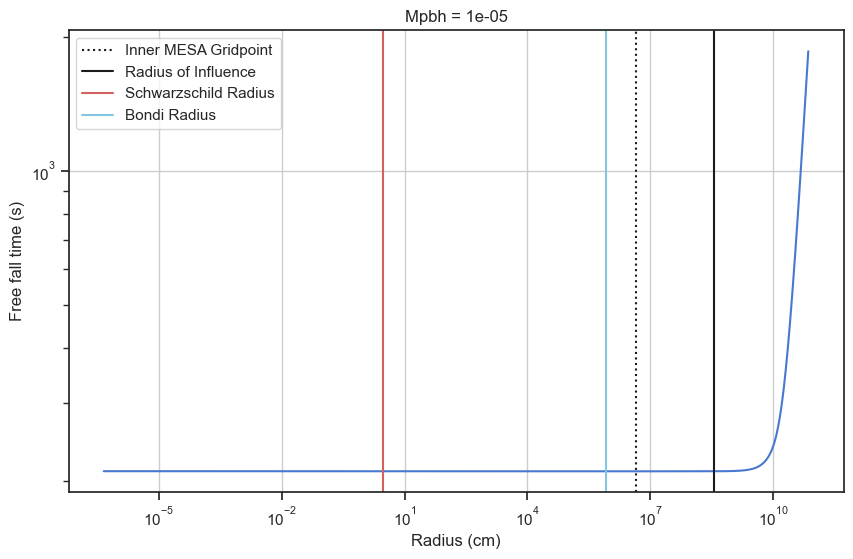

In [63]:
pbhmass = str(Mpbh/Msun)
fig, ax = plt.subplots(figsize=(10, 6))
  # Find transition point
transition_idx = np.where(~results['is_extrapolated'])[0][0]
transition_r = results['radius'][transition_idx]
ax.loglog(results['radius'], tff)
ax.axvline(transition_r, color='k', linestyle=':', label='Inner MESA Gridpoint')
ax.axvline(Rinf, color='k', linestyle='-', label='Radius of Influence')
ax.axvline(Rs, color='r', linestyle='-', label='Schwarzschild Radius')
ax.axvline(Rb, color='c', linestyle='-', label='Bondi Radius')
ax.set_xlabel('Radius (cm)')
ax.set_ylabel('Free fall time (s)')
print(Rinf)
ax.set_title(str('Mpbh = ')+pbhmass)
plt.legend()
ax.grid(True)